In [17]:
%matplotlib inline

In [6]:
import os
import glob
import numpy as np

def convert_seg_to_bbox(seg_label_path, bbox_label_path):
    with open(seg_label_path, 'r') as f:
        lines = f.readlines()
    
    bbox_lines = []
    for line in lines:
        parts = line.strip().split()
        class_id = 0
        
        # Extract all x,y coordinates
        coords = [float(coord) for coord in parts[1:]]
        points = np.array(coords).reshape(-1, 2)
        
        # Find min/max to create bounding box
        x_min, y_min = points.min(axis=0)
        x_max, y_max = points.max(axis=0)
        
        # Convert to YOLO format (x_center, y_center, width, height)
        x_center = (x_min + x_max) / 2
        y_center = (y_min + y_max) / 2
        width = x_max - x_min
        height = y_max - y_min
        
        bbox_lines.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")
    
    # Write to new label file
    with open(bbox_label_path, 'w') as f:
        f.write('\n'.join(bbox_lines))

# Process all segmentation labels
seg_label_dir = "../data/processed/meatballs/gt_masks"
bbox_label_dir = "../data/processed/meatballs_yolo/labels"
os.makedirs(bbox_label_dir, exist_ok=True)

for seg_file in glob.glob(os.path.join(seg_label_dir, "*.txt")):
    filename = os.path.basename(seg_file)
    bbox_file = os.path.join(bbox_label_dir, filename)
    convert_seg_to_bbox(seg_file, bbox_file)

In [7]:
import shutil

# Copy the images (you don't need to change these)
src_img_dir = "../data/processed/meatballs/images"
dst_img_dir = "../data/processed/meatballs_yolo/images"
os.makedirs(dst_img_dir, exist_ok=True)

for img_file in glob.glob(os.path.join(src_img_dir, "*.png")):
    shutil.copy(img_file, dst_img_dir)


In [8]:
import os
import random
import shutil
from pathlib import Path

def reorganize_existing_dataset(dataset_dir, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1, seed=42):
    """
    Reorganize an existing dataset with flat images and labels folders into train/val/test splits
    """
    # Set random seed for reproducibility
    random.seed(seed)
    
    # Input directories
    img_dir = os.path.join(dataset_dir, "images")
    label_dir = os.path.join(dataset_dir, "labels")
    
    # Get all image files before creating new directories
    image_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    random.shuffle(image_files)
    
    # Create subdirectories
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(img_dir, split), exist_ok=True)
        os.makedirs(os.path.join(label_dir, split), exist_ok=True)
    
    # Calculate split indices
    n_samples = len(image_files)
    train_end = int(n_samples * train_ratio)
    val_end = train_end + int(n_samples * val_ratio)
    
    # Split files
    train_files = image_files[:train_end]
    val_files = image_files[train_end:val_end]
    test_files = image_files[val_end:]
    
    # Move files to respective directories
    splits = {
        "train": train_files,
        "val": val_files,
        "test": test_files
    }
    
    for split, files in splits.items():
        for filename in files:
            # Move image
            src_img = os.path.join(img_dir, filename)
            dst_img = os.path.join(img_dir, split, filename)
            shutil.move(src_img, dst_img)
            
            # Move label (if exists)
            base_name = os.path.splitext(filename)[0]
            label_filename = f"{base_name}.txt"
            src_label = os.path.join(label_dir, label_filename)
            dst_label = os.path.join(label_dir, split, label_filename)
            
            if os.path.exists(src_label):
                shutil.move(src_label, dst_label)
    
    # Print statistics
    print(f"Dataset reorganization complete:")
    print(f"  Train: {len(train_files)} images")
    print(f"  Validation: {len(val_files)} images")
    print(f"  Test: {len(test_files)} images")
    
    # Create YAML file
    yaml_path = os.path.join(dataset_dir, "data.yaml")
    
    # Try to infer class names
    class_names = ["class0", "class1"]  # Default placeholder
    # Check for any label file to infer classes
    sample_dirs = [os.path.join(label_dir, split) for split in ["train", "val", "test"]]
    for dir_path in sample_dirs:
        label_files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]
        if label_files:
            # Take the first label file and find max class ID
            with open(os.path.join(dir_path, label_files[0]), 'r') as f:
                class_ids = set()
                for line in f:
                    parts = line.strip().split()
                    if parts:
                        class_ids.add(int(parts[0]))
            
            if class_ids:
                num_classes = max(class_ids) + 1
                class_names = [f"class{i}" for i in range(num_classes)]
            break
    
    yaml_content = f"""
# YOLOv8 dataset config
path: {os.path.abspath(dataset_dir)}
train: images/train
val: images/val
test: images/test

# Classes
nc: {len(class_names)}
names: {class_names}
"""

    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    
    print(f"Dataset YAML created at: {yaml_path}")
    print("Note: Update the class names in the YAML file to match your actual classes.")
    
    return yaml_path

# Example usage
dataset_dir = "../data/processed/meatballs_yolo"  # Contains images/ and labels/ folders
yaml_file = reorganize_existing_dataset(dataset_dir)

Dataset reorganization complete:
  Train: 140 images
  Validation: 40 images
  Test: 20 images
Dataset YAML created at: ../data/processed/meatballs_yolo\data.yaml
Note: Update the class names in the YAML file to match your actual classes.


In [31]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def show_yolo_labels(img_path, label_path=None):
    """
    Simple function to display an image with its YOLO labels in a Jupyter notebook.
    
    Args:
        img_path (str): Path to the image
        label_path (str, optional): Path to the label file. If None, tries to find label 
                                    by replacing 'images' with 'labels' in the path
                                    and changing extension to .txt
    """
    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB for matplotlib
    height, width, _ = img.shape
    
    # Auto-detect label path if not provided
    if label_path is None:
        label_path = img_path.replace('images', 'labels').replace('.png', '.txt').replace('.jpg', '.txt')
    
    # Red color for all bounding boxes (R,G,B)
    red_color = (255, 0, 0)
    
    # Load labels
    try:
        with open(label_path, 'r') as f:
            lines = f.readlines()
            
        # Draw each bounding box
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 5:
                x_center, y_center, w, h = map(float, parts[1:5])
                
                # Convert normalized coordinates to pixel coordinates
                x1 = int((x_center - w/2) * width)
                y1 = int((y_center - h/2) * height)
                x2 = int((x_center + w/2) * width)
                y2 = int((y_center + h/2) * height)
                
                # Draw rectangle with red color and thin line (thickness=1)
                cv2.rectangle(img, (x1, y1), (x2, y2), red_color, 1)
                
                # No label text
        
        # Display image with bounding boxes
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Image with YOLO labels: {len(lines)} objects detected")
        plt.show()
        
    except FileNotFoundError:
        print(f"Label file not found: {label_path}")
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image (no labels found)")
        plt.show()
    except Exception as e:
        print(f"Error reading labels: {e}")
        plt.figure(figsize=(12, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Image (error reading labels)")
        plt.show()

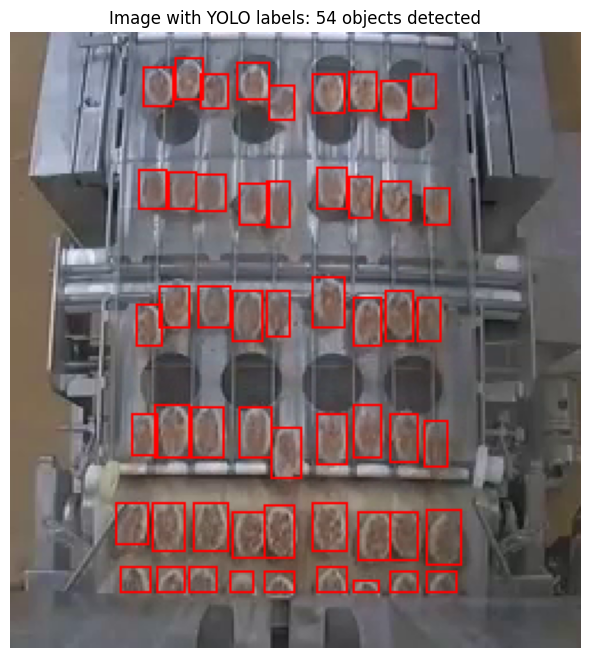

In [ ]:
img = 'C:/Users/gtoft/OneDrive/DTU/4_Semester_AS/Master_Thesis/auto-annotation-sam/data/processed/meatballs_yolo/images/test/frame_000072.png'

result = show_yolo_labels(img)

# let's train


In [ ]:
from ultralytics import YOLO
import numpy as np
import torch

# Load your model
model = YOLO("yolov8n.pt")

In [15]:
data_path = '../data/processed/meatballs_yolo/data.yaml'

results = model.train(
    data=data_path, 
    epochs=100, 
    imgsz=640,
    batch=16,
    patience=50,
    pretrained=True,
    device=0  # GPU id (0, 1, 2, etc.) or 'cpu'
)

Ultralytics 8.3.111  Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=../data/processed/meatballs_yolo/data.yaml, epochs=100, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

train: Scanning C:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\data\processed\meatballs_yolo\labels\train... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<00:00, 883.39it/s]

train: New cache created: C:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\data\processed\meatballs_yolo\labels\train.cache


val: Fast image access  (ping: 0.00.0 ms, read: 878.9193.6 MB/s, size: 128.6 KB)


val: Scanning C:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\data\processed\meatballs_yolo\labels\val... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 648.69it/s]

val: New cache created: C:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\data\processed\meatballs_yolo\labels\val.cache


Plotting labels to runs\detect\train3\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train3
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.52G      2.224      3.505      1.465        936        640: 100%|██████████| 9/9 [00:05<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         40       2118      0.163      0.924      0.215      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.83G      1.469       2.13          1        984        640: 100%|██████████| 9/9 [00:02<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.01it/s]

                   all         40       2118      0.169      0.959      0.797      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.57G      1.442      1.154     0.9697        627        640: 100%|██████████| 9/9 [00:01<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

                   all         40       2118          1      0.653      0.923      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.52G      1.372     0.9235     0.9671        842        640: 100%|██████████| 9/9 [00:01<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.18it/s]

                   all         40       2118      0.999      0.818      0.948      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.56G      1.295     0.8003     0.9608        993        640: 100%|██████████| 9/9 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

                   all         40       2118      0.942      0.927      0.971      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.44G       1.32     0.7691     0.9608       1103        640: 100%|██████████| 9/9 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         40       2118      0.994      0.985      0.994      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.02G      1.279     0.7069     0.9605        846        640: 100%|██████████| 9/9 [00:01<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         40       2118      0.995      0.984      0.994      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.99G      1.237     0.6939     0.9509        599        640: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.22it/s]

                   all         40       2118      0.988      0.992      0.993      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.99G      1.252     0.6871     0.9536        928        640: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         40       2118      0.991      0.992      0.994      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.99G      1.203     0.6403     0.9398        852        640: 100%|██████████| 9/9 [00:01<00:00,  5.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.03it/s]

                   all         40       2118      0.991      0.994      0.995      0.661



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.43G       1.24     0.6426      0.934       1015        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.37it/s]

                   all         40       2118      0.993      0.992      0.995      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       3.3G      1.178     0.6209     0.9207       1074        640: 100%|██████████| 9/9 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.49it/s]

                   all         40       2118      0.994      0.995      0.995      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.87G      1.183     0.6233     0.9358        957        640: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         40       2118      0.992      0.994      0.994      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.27G      1.161     0.6079     0.9183       1130        640: 100%|██████████| 9/9 [00:01<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.29it/s]

                   all         40       2118      0.989      0.993      0.994       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100       3.5G      1.151     0.6154     0.9296       1070        640: 100%|██████████| 9/9 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.27it/s]

                   all         40       2118      0.992      0.994      0.995      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.38G      1.119     0.5995     0.9276        614        640: 100%|██████████| 9/9 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.53it/s]

                   all         40       2118      0.991      0.993      0.994      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.94G      1.166     0.5967     0.9248       1118        640: 100%|██████████| 9/9 [00:01<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         40       2118      0.992      0.993      0.993      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.94G       1.23     0.5997     0.9445        885        640: 100%|██████████| 9/9 [00:01<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         40       2118      0.994      0.996      0.994      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.94G      1.198      0.585      0.941        914        640: 100%|██████████| 9/9 [00:01<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

                   all         40       2118      0.991      0.995      0.994      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.94G      1.136     0.5703     0.9233        873        640: 100%|██████████| 9/9 [00:01<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         40       2118      0.993      0.995      0.995       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.94G      1.157      0.571     0.9364       1107        640: 100%|██████████| 9/9 [00:01<00:00,  5.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

                   all         40       2118      0.995      0.992      0.995      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.94G      1.161     0.5761     0.9335        936        640: 100%|██████████| 9/9 [00:01<00:00,  5.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         40       2118      0.994      0.993      0.994      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.35G      1.145     0.5776     0.9376        989        640: 100%|██████████| 9/9 [00:01<00:00,  4.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         40       2118      0.993      0.995      0.993      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.32G      1.104     0.5513     0.9131        884        640: 100%|██████████| 9/9 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.46it/s]

                   all         40       2118      0.992      0.995      0.993      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.95G      1.091     0.5453     0.9136        665        640: 100%|██████████| 9/9 [00:01<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.43it/s]

                   all         40       2118      0.991      0.997      0.995      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.38G      1.097     0.5451      0.911        894        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.25it/s]

                   all         40       2118      0.994      0.994      0.995      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.39G      1.086     0.5349     0.9051        940        640: 100%|██████████| 9/9 [00:01<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         40       2118      0.994      0.996      0.995      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100       3.6G      1.068     0.5311     0.9058        671        640: 100%|██████████| 9/9 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.45it/s]

                   all         40       2118      0.993      0.996      0.993      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.93G      1.078     0.5367     0.9099       1257        640: 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.44it/s]

                   all         40       2118      0.991      0.996      0.993      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.32G       1.06     0.5218     0.9075        741        640: 100%|██████████| 9/9 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.41it/s]

                   all         40       2118      0.991      0.996      0.993      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.01G      1.045     0.5107     0.9041        733        640: 100%|██████████| 9/9 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         40       2118      0.992      0.996      0.993      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.49G      1.033     0.5105     0.8957       1131        640: 100%|██████████| 9/9 [00:02<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         40       2118      0.992      0.995      0.995      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.07G      1.033     0.5083     0.9022       1241        640: 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.21it/s]

                   all         40       2118      0.992      0.996      0.995      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.43G      1.067     0.5133     0.9041        672        640: 100%|██████████| 9/9 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         40       2118      0.992      0.995      0.995      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.69G      1.032     0.5071     0.8871        653        640: 100%|██████████| 9/9 [00:02<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         40       2118      0.991      0.998      0.994      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.91G      1.024      0.496     0.8925        839        640: 100%|██████████| 9/9 [00:02<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.98it/s]

                   all         40       2118      0.991      0.996      0.994      0.732



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.91G      1.031     0.4984     0.9009        646        640: 100%|██████████| 9/9 [00:02<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

                   all         40       2118      0.991      0.998      0.995      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.91G      1.023     0.4982     0.9002        897        640: 100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         40       2118      0.991      0.998      0.994      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.91G      1.031      0.497     0.9022        689        640: 100%|██████████| 9/9 [00:02<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         40       2118      0.992      0.999      0.995      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.32G      1.022     0.4912     0.9016        730        640: 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.68it/s]

                   all         40       2118      0.995      0.993      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.48G      1.035      0.503     0.8944        839        640: 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.92it/s]

                   all         40       2118      0.993      0.996      0.995      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.12G      1.006     0.4861      0.891       1029        640: 100%|██████████| 9/9 [00:02<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.33it/s]

                   all         40       2118      0.992      0.998      0.995       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.53G     0.9857     0.4712     0.8835        811        640: 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.12it/s]

                   all         40       2118      0.992      0.998      0.995      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.88G      1.002     0.4731     0.8933       1128        640: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

                   all         40       2118      0.993      0.997      0.995      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.34G     0.9884     0.4889     0.8889        737        640: 100%|██████████| 9/9 [00:02<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         40       2118      0.991      0.999      0.995      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.91G      0.985     0.4697     0.8851        935        640: 100%|██████████| 9/9 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         40       2118      0.991      0.999      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.79G     0.9767     0.4638     0.8796        968        640: 100%|██████████| 9/9 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.09it/s]

                   all         40       2118      0.991      0.999      0.995      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100       3.3G     0.9717     0.4521     0.8886        939        640: 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         40       2118      0.991      0.998      0.995      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.83G      1.006     0.4796     0.8924        615        640: 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

                   all         40       2118       0.99      0.998      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.25G     0.9932      0.469      0.881       1076        640: 100%|██████████| 9/9 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.62it/s]

                   all         40       2118      0.992      0.998      0.995      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.94G     0.9796     0.4565      0.887        890        640: 100%|██████████| 9/9 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         40       2118       0.99      0.998      0.995      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.95G     0.9763     0.4541     0.8856        784        640: 100%|██████████| 9/9 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.85it/s]

                   all         40       2118      0.992      0.997      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.95G      0.971      0.451     0.8843       1087        640: 100%|██████████| 9/9 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.73it/s]

                   all         40       2118      0.992      0.998      0.995      0.744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.95G     0.9697     0.4464      0.888       1165        640: 100%|██████████| 9/9 [00:01<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.88it/s]

                   all         40       2118      0.993      0.998      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.95G     0.9708     0.4498     0.8867        817        640: 100%|██████████| 9/9 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         40       2118      0.992      0.998      0.995      0.734



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.38G     0.9629      0.448     0.8834        809        640: 100%|██████████| 9/9 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.76it/s]

                   all         40       2118      0.993      0.998      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.56G     0.9556      0.441     0.8797        951        640: 100%|██████████| 9/9 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.37it/s]

                   all         40       2118      0.993      0.998      0.995      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.52G     0.9475      0.436     0.8803        871        640: 100%|██████████| 9/9 [00:01<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         40       2118      0.992      0.999      0.995       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.49G     0.9654     0.4393     0.8757       1048        640: 100%|██████████| 9/9 [00:01<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.10it/s]

                   all         40       2118      0.992      0.998      0.995      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.44G     0.9603     0.4439     0.8901        826        640: 100%|██████████| 9/9 [00:01<00:00,  4.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.16it/s]

                   all         40       2118      0.993      0.997      0.995      0.731



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.17G     0.9814     0.4533     0.8882       1282        640: 100%|██████████| 9/9 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.08it/s]

                   all         40       2118      0.993      0.998      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.37G     0.9556     0.4426     0.8744        818        640: 100%|██████████| 9/9 [00:01<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.39it/s]

                   all         40       2118      0.993      0.998      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.33G     0.9448     0.4314      0.877        819        640: 100%|██████████| 9/9 [00:01<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.85it/s]

                   all         40       2118      0.992      0.998      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.45G     0.9348     0.4284     0.8848        909        640: 100%|██████████| 9/9 [00:01<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.51it/s]

                   all         40       2118      0.993      0.997      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.47G     0.9392     0.4333     0.8758        858        640: 100%|██████████| 9/9 [00:01<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.07it/s]

                   all         40       2118      0.992      0.999      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.26G      0.938     0.4285     0.8826       1109        640: 100%|██████████| 9/9 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.58it/s]

                   all         40       2118      0.993      0.998      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.29G     0.9415     0.4251     0.8822       1130        640: 100%|██████████| 9/9 [00:01<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.55it/s]

                   all         40       2118      0.994      0.998      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.45G     0.9496     0.4377     0.8789        613        640: 100%|██████████| 9/9 [00:01<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.02it/s]

                   all         40       2118      0.993      0.999      0.995      0.735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.26G     0.9338     0.4227      0.877        976        640: 100%|██████████| 9/9 [00:01<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         40       2118      0.994      0.996      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.01G     0.9382      0.421     0.8755        916        640: 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.69it/s]

                   all         40       2118      0.993      0.998      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.07G     0.9322     0.4182     0.8778        941        640: 100%|██████████| 9/9 [00:01<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         40       2118      0.993      0.997      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.16G     0.9329     0.4188     0.8774        846        640: 100%|██████████| 9/9 [00:01<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.47it/s]

                   all         40       2118      0.993      0.998      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.82G     0.9281      0.414     0.8732        988        640: 100%|██████████| 9/9 [00:01<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.77it/s]

                   all         40       2118      0.994      0.998      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.83G      0.929     0.4188     0.8831        717        640: 100%|██████████| 9/9 [00:01<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.96it/s]

                   all         40       2118      0.994      0.998      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100       3.7G      0.923     0.4125     0.8783        726        640: 100%|██████████| 9/9 [00:01<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.42it/s]

                   all         40       2118      0.994      0.999      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.29G     0.9094     0.4067     0.8709        817        640: 100%|██████████| 9/9 [00:01<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.38it/s]

                   all         40       2118      0.994      0.999      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.62G     0.9246     0.4142     0.8778        708        640: 100%|██████████| 9/9 [00:01<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         40       2118      0.994      0.999      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.48G     0.9276     0.4126     0.8681        988        640: 100%|██████████| 9/9 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         40       2118      0.994      0.999      0.995       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.82G     0.9194     0.4074     0.8761        723        640: 100%|██████████| 9/9 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.28it/s]

                   all         40       2118      0.994      0.999      0.995      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      4.04G     0.9187     0.4101      0.873        740        640: 100%|██████████| 9/9 [00:01<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.64it/s]

                   all         40       2118      0.993      0.998      0.995      0.753



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.73G     0.9211     0.4062     0.8779        963        640: 100%|██████████| 9/9 [00:01<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         40       2118      0.993      0.999      0.995      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.29G     0.9077     0.4026     0.8781        717        640: 100%|██████████| 9/9 [00:01<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.95it/s]

                   all         40       2118      0.993      0.999      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.91G     0.9176     0.4055     0.8756        906        640: 100%|██████████| 9/9 [00:01<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.64it/s]

                   all         40       2118      0.993      0.999      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.92G     0.9099      0.406     0.8684        822        640: 100%|██████████| 9/9 [00:02<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.79it/s]

                   all         40       2118      0.993      0.999      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.92G     0.9045     0.3992     0.8701        962        640: 100%|██████████| 9/9 [00:01<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.53it/s]

                   all         40       2118      0.993      0.999      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.92G     0.9126     0.4062     0.8659       1091        640: 100%|██████████| 9/9 [00:01<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

                   all         40       2118      0.994      0.997      0.995       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.92G     0.9166     0.4123     0.8792        781        640: 100%|██████████| 9/9 [00:01<00:00,  4.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         40       2118      0.993      0.997      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.92G     0.8981     0.3966     0.8696        775        640: 100%|██████████| 9/9 [00:01<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         40       2118      0.993      0.998      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.92G     0.8964     0.3944      0.868        889        640: 100%|██████████| 9/9 [00:01<00:00,  5.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.20it/s]

                   all         40       2118      0.994      0.998      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.92G     0.9009     0.3967     0.8664        901        640: 100%|██████████| 9/9 [00:02<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         40       2118      0.993      0.999      0.995      0.748


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.92G     0.9055     0.4181     0.8892        605        640: 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.07it/s]

                   all         40       2118      0.993      0.999      0.995      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.92G     0.9046     0.4096     0.8857        614        640: 100%|██████████| 9/9 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.16it/s]

                   all         40       2118      0.992      0.998      0.995      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.92G     0.8936     0.4081     0.8825        558        640: 100%|██████████| 9/9 [00:02<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.89it/s]

                   all         40       2118      0.992      0.998      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.92G     0.8889     0.3944     0.8877        588        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.30it/s]

                   all         40       2118      0.992      0.998      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.92G     0.8766      0.387     0.8826        586        640: 100%|██████████| 9/9 [00:01<00:00,  5.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.28it/s]

                   all         40       2118      0.993      0.999      0.995      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.92G     0.8813     0.3825     0.8767        590        640: 100%|██████████| 9/9 [00:01<00:00,  5.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.57it/s]

                   all         40       2118      0.993      0.998      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.92G     0.8775     0.3852     0.8753        629        640: 100%|██████████| 9/9 [00:01<00:00,  5.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

                   all         40       2118      0.992      0.999      0.995      0.746



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.92G     0.8811     0.3887      0.875        633        640: 100%|██████████| 9/9 [00:01<00:00,  5.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.31it/s]

                   all         40       2118      0.992      0.999      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.92G     0.8826     0.3892     0.8732        611        640: 100%|██████████| 9/9 [00:01<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.48it/s]

                   all         40       2118      0.992      0.999      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.92G     0.8714     0.3805     0.8744        611        640: 100%|██████████| 9/9 [00:01<00:00,  5.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.32it/s]

                   all         40       2118      0.993      0.999      0.995       0.75



100 epochs completed in 0.094 hours.
Optimizer stripped from runs\detect\train3\weights\last.pt, 6.3MB
Optimizer stripped from runs\detect\train3\weights\best.pt, 6.3MB

Validating runs\detect\train3\weights\best.pt...
Ultralytics 8.3.111  Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.22s/it]


                   all         40       2118      0.993      0.998      0.995      0.753
Speed: 0.3ms preprocess, 4.0ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs\detect\train3


# Let's do inference

In [ ]:
from ultralytics import YOLO
import os

# Load your trained model
model_path = "runs/detect/meatball_yolo/weights/best.pt"  # Update this to your model path
model = YOLO(model_path)

# Path to your video
video_path = "../data/raw/FakeGrease6.mp4"  # Update this to your video path

# Output settings
output_folder = "yolo_inference"
os.makedirs(output_folder, exist_ok=True)
video_name = os.path.basename(video_path)
video_name_without_ext = os.path.splitext(video_name)[0]
output_path = os.path.join(output_folder, f"{video_name_without_ext}_pred.mp4")

# Run inference with tracking
results = model.track(
    source=video_path,
    conf=0.7,  # Confidence threshold
    iou=0.45,
    save=True,
    project=output_folder,
    name=video_name_without_ext,
    stream=False,  # Set to True for very large videos to process frame by frame
    persist=True,
)

# Print detection summary
print(f"Processing complete! Video saved to: {output_path}")



WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/472) c:\Users\GustavToft\Projects\auto-annotation-sam\notebooks\..\data\raw\FakeGrease6.mp4: 640x640 44 class0s, 100.7ms
video 1/1 (frame 2/472) c:\Users\GustavToft\Projects\auto-annotation-sam\notebooks\..\data\raw\FakeGrease6.mp4: 640x640 44 class0s, 88.9ms
video 1/1 (frame 3/472) c:\Users\GustavToft\Projects\auto-annotation-sam\notebooks\..\data\raw\FakeGrease6.mp4: 640x640 44 class0s, 85.7ms
video 1/1 (frame 4/472) c:\Users\GustavT

# Playing around with features

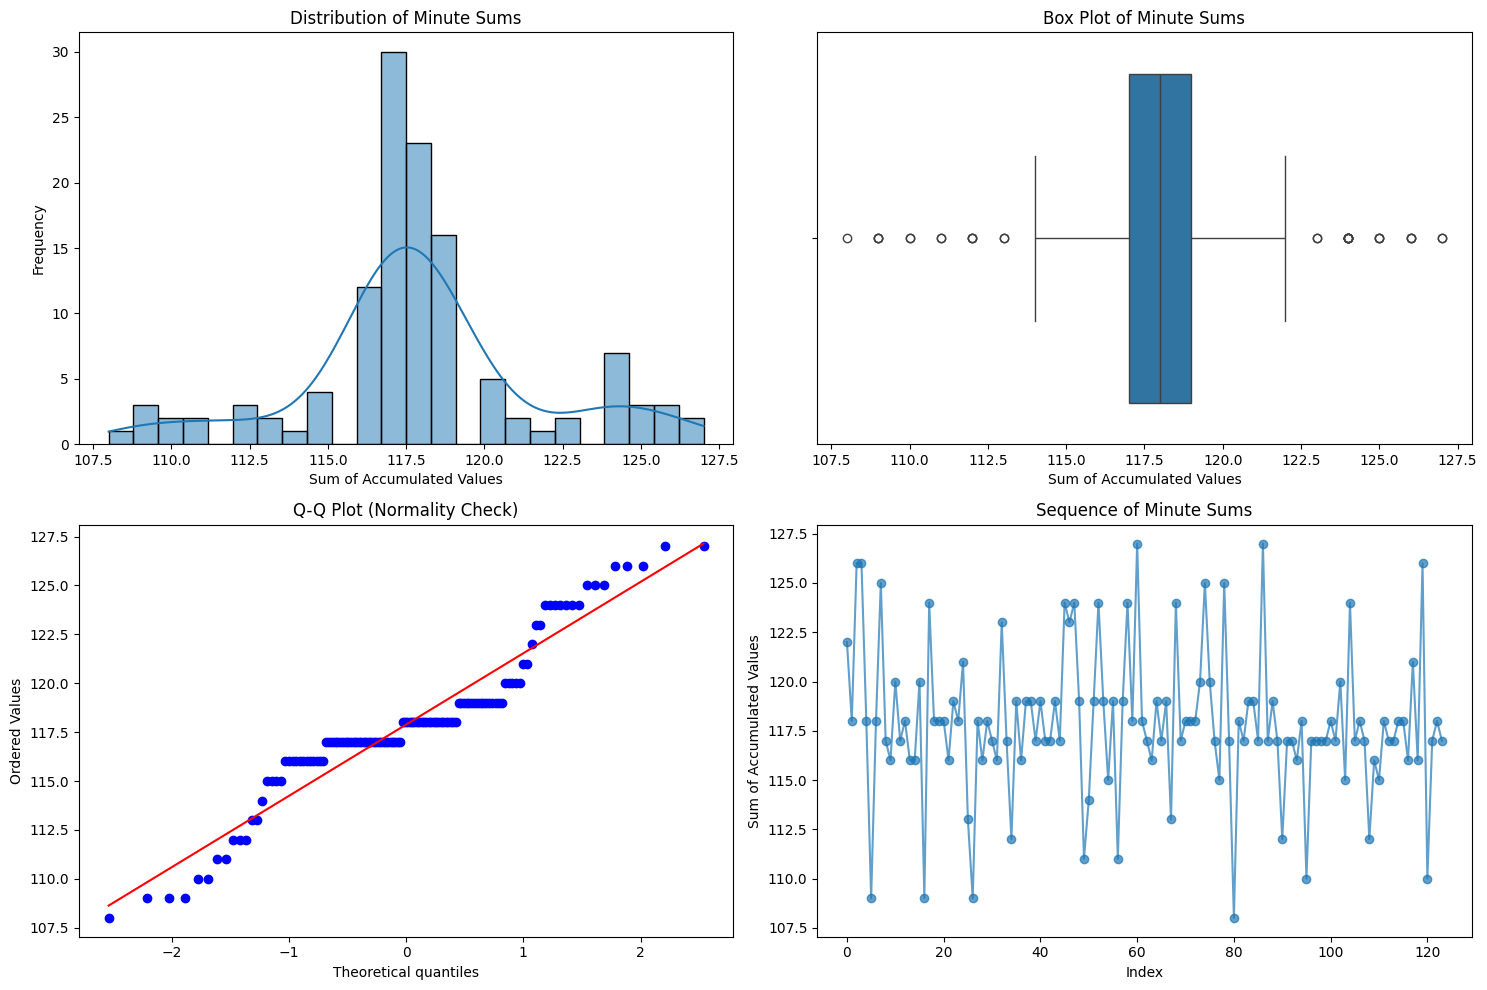


===== Statistical Summary =====
Number of data points: 124
Mean: 117.89
Median: 118.00
Standard Deviation: 3.73
Minimum: 108.00
Maximum: 127.00
25th percentile: 117.00
75th percentile: 119.00
Skewness: 0.0700
Kurtosis: 0.8244


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def analyze_minute_sums(csv_filepath):
    """
    Analyze the distribution of Accumulated Value sums by minute,
    excluding the first and last entries.
    
    Args:
        csv_filepath (str): Path to the CSV file
        
    Returns:
        dict: Dictionary containing statistics about the distribution
    """
    try:
        # First, calculate the minute sums using our previous function
        minute_sums = sum_accumulated_value_by_minute(csv_filepath)
        
        # Remove first and last entries as requested
        if len(minute_sums) >= 3:  # Ensure we have at least 3 entries
            filtered_sums = minute_sums[1:-1]
        else:
            filtered_sums = minute_sums
            print("Warning: Not enough data points to remove first and last entries")
        
        # Convert to numpy array for easier analysis
        data = np.array(filtered_sums)
        
        # Calculate statistics
        stats_dict = {
            'count': len(data),
            'mean': np.mean(data),
            'median': np.median(data),
            'std_dev': np.std(data),
            'min': np.min(data),
            'max': np.max(data),
            '25th_percentile': np.percentile(data, 25),
            '75th_percentile': np.percentile(data, 75),
            'skewness': stats.skew(data),
            'kurtosis': stats.kurtosis(data)
        }
        
        # Set up the figure and subplots
        plt.figure(figsize=(15, 10))
        
        # Plot 1: Histogram with KDE
        plt.subplot(2, 2, 1)
        sns.histplot(data, kde=True)
        plt.title('Distribution of Minute Sums')
        plt.xlabel('Sum of Accumulated Values')
        plt.ylabel('Frequency')
        
        # Plot 2: Box plot
        plt.subplot(2, 2, 2)
        sns.boxplot(x=data)
        plt.title('Box Plot of Minute Sums')
        plt.xlabel('Sum of Accumulated Values')
        
        # Plot 3: Q-Q plot to check for normality
        plt.subplot(2, 2, 3)
        stats.probplot(data, plot=plt)
        plt.title('Q-Q Plot (Normality Check)')
        
        # Plot 4: Line plot of the values
        plt.subplot(2, 2, 4)
        plt.plot(data, marker='o', linestyle='-', alpha=0.7)
        plt.title('Sequence of Minute Sums')
        plt.xlabel('Index')
        plt.ylabel('Sum of Accumulated Values')
        
        plt.tight_layout()
        plt.show()
        
        # Print the statistics
        print("\n===== Statistical Summary =====")
        print(f"Number of data points: {stats_dict['count']}")
        print(f"Mean: {stats_dict['mean']:.2f}")
        print(f"Median: {stats_dict['median']:.2f}")
        print(f"Standard Deviation: {stats_dict['std_dev']:.2f}")
        print(f"Minimum: {stats_dict['min']:.2f}")
        print(f"Maximum: {stats_dict['max']:.2f}")
        print(f"25th percentile: {stats_dict['25th_percentile']:.2f}")
        print(f"75th percentile: {stats_dict['75th_percentile']:.2f}")
        print(f"Skewness: {stats_dict['skewness']:.4f}")
        print(f"Kurtosis: {stats_dict['kurtosis']:.4f}")
        
        # Return the statistics dictionary
        return stats_dict
        
    except Exception as e:
        print(f"Error analyzing data: {str(e)}")
        return {}


# Helper function to calculate minute sums (copy from previous code)
def sum_accumulated_value_by_minute(csv_filepath):
    """
    Sum the "Accumulated Value" column grouped by minute from the CSV file.
    
    Args:
        csv_filepath (str): Path to the CSV file
        
    Returns:
        list: List of sums for each minute group
    """
    try:
        # Read the CSV file
        df = pd.read_csv(csv_filepath)
        
        # Ensure numeric values in "Accumulated Value" column
        df['Accumulated Value'] = pd.to_numeric(df['Accumulated Value'], errors='coerce')
        
        # Group by minute based on the 'From' column
        minute_groups = {}
        
        for _, row in df.iterrows():
            timestamp = row['From']
            value = row['Accumulated Value']
            
            # Skip if value is NaN
            if pd.isna(value):
                continue
                
            # Extract minute from timestamp using regex
            import re
            match = re.search(r'at\s+(\d+):(\d+)\s+(AM|PM)', timestamp)
            if match:
                hour = int(match.group(1))
                minute = int(match.group(2))
                am_pm = match.group(3)
                
                # Convert to 24-hour format
                if am_pm == "PM" and hour < 12:
                    hour += 12
                elif am_pm == "AM" and hour == 12:
                    hour = 0
                    
                minute_key = f"{hour:02d}:{minute:02d}"
            else:
                # If regex fails, use the row index as a group (batches of 60)
                row_idx = df.index.get_loc(row.name)
                minute_key = f"Group_{row_idx // 60}"
            
            # Add to the appropriate minute group
            if minute_key not in minute_groups:
                minute_groups[minute_key] = 0
                
            minute_groups[minute_key] += value
        
        # Return just the sums as a list
        return list(minute_groups.values())
        
    except Exception as e:
        print(f"Error processing CSV: {str(e)}")
        return []


stats = analyze_minute_sums('../data/raw/Live_chart.csv')

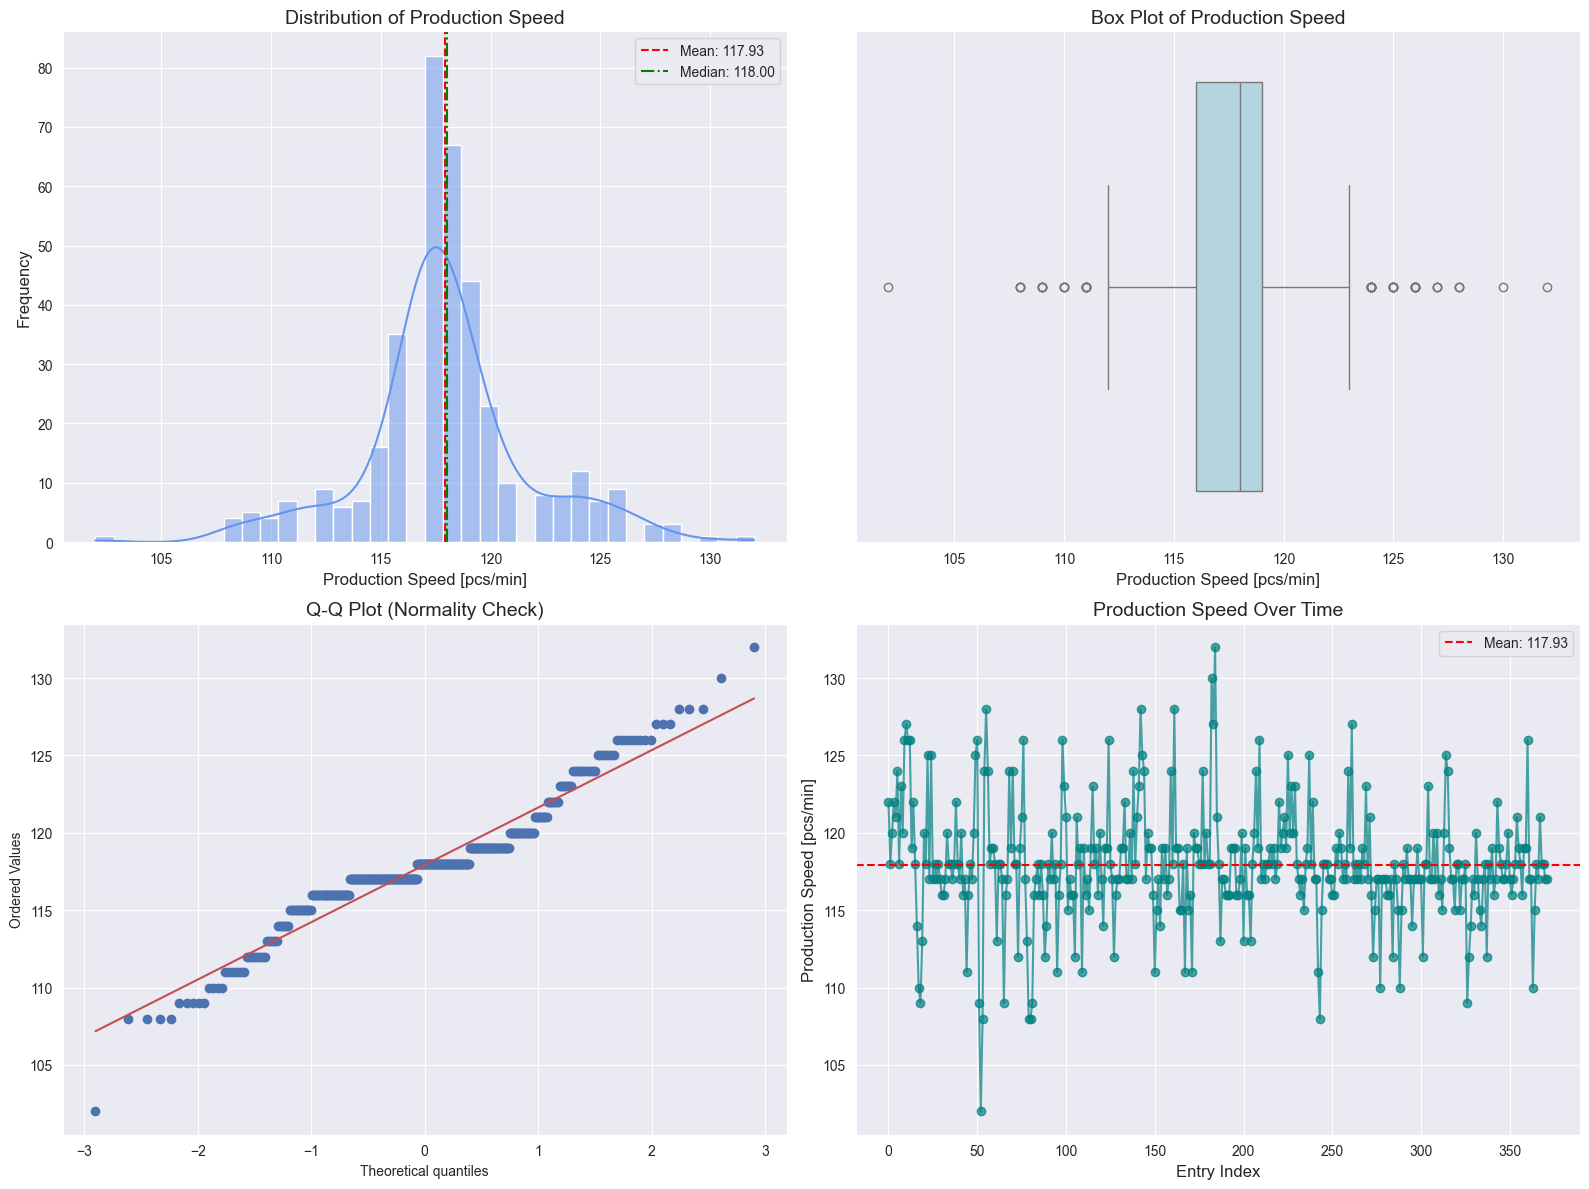


===== Production Speed Statistical Summary =====
Number of entries analyzed: 372
Mean production speed: 117.93 pcs/min
Median production speed: 118.00 pcs/min
Standard Deviation: 3.81 pcs/min
Minimum: 102.00 pcs/min
Maximum: 132.00 pcs/min
25th percentile: 116.00 pcs/min
75th percentile: 119.00 pcs/min
Skewness: 0.1107
Kurtosis: 1.8189


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import re

def analyze_production_speed(csv_filepath, window_size=3, plot_style='darkgrid'):
    """
    Calculate production speed using the "Accumulated Value" column and a sliding window.
    Skips the first 2 entries and the last entry for analysis.
    
    Args:
        csv_filepath (str): Path to the CSV file
        window_size (int): Size of the sliding window for calculating production speed
        plot_style (str): Seaborn plot style ('darkgrid', 'whitegrid', 'dark', 'white', 'ticks')
        
    Returns:
        dict: Dictionary containing statistics about the distribution
    """
    try:
        # Set the plot style
        sns.set_style(plot_style)
        
        # Read the CSV file
        df = pd.read_csv(csv_filepath)
        
        # Ensure the Accumulated Value column is numeric
        df['Accumulated Value'] = pd.to_numeric(df['Accumulated Value'], errors='coerce')
        
        # Calculate the rolling sum using the specified window size
        df['Production Speed'] = df['Accumulated Value'].rolling(window=window_size).sum()
        
        # Drop the first (window_size-1) rows since they don't have complete windows
        production_speed_df = df.iloc[window_size-1:].copy()
        
        # Also remove the last entry
        if len(production_speed_df) > 1:
            production_speed_df = production_speed_df.iloc[:-1]
        
        # Extract minute information from timestamps
        def extract_minute(timestamp):
            match = re.search(r'at\s+(\d+):(\d+)\s+(AM|PM)', str(timestamp))
            if match:
                hour = int(match.group(1))
                minute = int(match.group(2))
                am_pm = match.group(3)
                
                # Convert to 24-hour format
                if am_pm == "PM" and hour < 12:
                    hour += 12
                elif am_pm == "AM" and hour == 12:
                    hour = 0
                    
                return f"{hour:02d}:{minute:02d}"
            else:
                return None
        
        # Extract time information if available
        if 'From' in production_speed_df.columns:
            production_speed_df['minute_key'] = production_speed_df['From'].apply(extract_minute)
        
        # Get the production speed values
        production_speeds = production_speed_df['Production Speed'].values
        
        # Convert to numpy array for analysis
        data = np.array(production_speeds)
        
        # Calculate statistics
        stats_dict = {
            'count': len(data),
            'mean': np.mean(data),
            'median': np.median(data),
            'std_dev': np.std(data),
            'min': np.min(data),
            'max': np.max(data),
            '25th_percentile': np.percentile(data, 25),
            '75th_percentile': np.percentile(data, 75),
            'skewness': stats.skew(data) if len(data) >= 3 else np.nan,
            'kurtosis': stats.kurtosis(data) if len(data) >= 4 else np.nan
        }
        
        # Set up the figure and subplots - only 4 plots now
        plt.figure(figsize=(16, 12))
        
        # Plot 1: Histogram with KDE
        plt.subplot(2, 2, 1)
        sns.histplot(data, kde=True, color='cornflowerblue')
        plt.axvline(stats_dict['mean'], color='red', linestyle='--', label=f"Mean: {stats_dict['mean']:.2f}")
        plt.axvline(stats_dict['median'], color='green', linestyle='-.', label=f"Median: {stats_dict['median']:.2f}")
        plt.title('Distribution of Production Speed', fontsize=14)
        plt.xlabel('Production Speed [pcs/min]', fontsize=12)
        plt.ylabel('Frequency', fontsize=12)
        plt.legend()
        
        # Plot 2: Box plot
        plt.subplot(2, 2, 2)
        sns.boxplot(x=data, color='lightblue')
        plt.title('Box Plot of Production Speed', fontsize=14)
        plt.xlabel('Production Speed [pcs/min]', fontsize=12)
        
        # Plot 3: Q-Q plot to check for normality
        plt.subplot(2, 2, 3)
        stats.probplot(data, plot=plt)
        plt.title('Q-Q Plot (Normality Check)', fontsize=14)
        
        # Plot 4: Line plot of the values over time
        plt.subplot(2, 2, 4)
        plt.plot(data, marker='o', linestyle='-', alpha=0.7, color='teal')
        plt.axhline(stats_dict['mean'], color='red', linestyle='--', label=f"Mean: {stats_dict['mean']:.2f}")
        plt.title('Production Speed Over Time', fontsize=14)
        plt.xlabel('Entry Index', fontsize=12)
        plt.ylabel('Production Speed [pcs/min]', fontsize=12)
        plt.legend()
        
        plt.tight_layout()
        plt.show()
        
        # Print the statistics
        print("\n===== Production Speed Statistical Summary =====")
        print(f"Number of entries analyzed: {stats_dict['count']}")
        print(f"Mean production speed: {stats_dict['mean']:.2f} pcs/min")
        print(f"Median production speed: {stats_dict['median']:.2f} pcs/min")
        print(f"Standard Deviation: {stats_dict['std_dev']:.2f} pcs/min")
        print(f"Minimum: {stats_dict['min']:.2f} pcs/min")
        print(f"Maximum: {stats_dict['max']:.2f} pcs/min")
        print(f"25th percentile: {stats_dict['25th_percentile']:.2f} pcs/min")
        print(f"75th percentile: {stats_dict['75th_percentile']:.2f} pcs/min")
        print(f"Skewness: {stats_dict['skewness']:.4f}")
        print(f"Kurtosis: {stats_dict['kurtosis']:.4f}")
        
        return stats_dict, production_speed_df
        
    except Exception as e:
        print(f"Error analyzing data: {str(e)}")
        import traceback
        traceback.print_exc()
        return {}, None

# Example usage in a notebook:
stats, df = analyze_production_speed('../data/raw/Live_chart.csv', window_size=3)

In [1]:
from ultralytics import YOLO
import torch.nn.functional as F

class MCDropoutTracker:
    def __init__(self, model_path, dropout_rate=0.05):
        self.model_path = model_path
        self.dropout_rate = dropout_rate
        # Initialize model for immediate use if needed
        self.model = self._create_fresh_model()
        
    def _create_fresh_model(self):
        """Create a fresh model instance with dropout applied"""
        # Load a new model instance
        model = YOLO(self.model_path)
        
        # Find detection head
        detect_head = None
        for module in model.model.modules():
            if 'Detect' in str(type(module)):
                detect_head = module
                break
                
        if detect_head is None:
            raise ValueError("Could not find detection head")
            
        # Store original forward method
        original_forward = detect_head.forward
        
        # Define new forward with dropout
        def forward_with_dropout(x, *args, **kwargs):
            # Apply dropout to feature maps
            if isinstance(x, list):
                x = [F.dropout(xi, p=self.dropout_rate, training=True) for xi in x]
            else:
                x = F.dropout(x, p=self.dropout_rate, training=True)
            
            # Call original forward
            return original_forward(x, *args, **kwargs)
            
        # Replace forward method
        detect_head.forward = forward_with_dropout
        
        # Set to train mode to enable dropout
        model.model.train()
        
        return model
    
    def fine_tune(self, data_yaml, epochs=5, batch_size=16, reset_model=False, **kwargs):
        """Fine-tune the model with dropout enabled
        
        Args:
            data_yaml: Path to data YAML file
            epochs: Number of training epochs
            batch_size: Batch size for training
            reset_model: Whether to create a fresh model before fine-tuning
            **kwargs: Additional arguments for YOLO training
        """
        # Create a fresh model if requested or if model doesn't exist
        if reset_model or not hasattr(self, 'model'):
            self.model = self._create_fresh_model()
        
        # Make sure dropout is active during training
        self.model.model.train()
        
        # Start fine-tuning
        results = self.model.train(
            data=data_yaml,
            epochs=epochs,
            batch=batch_size,
            **kwargs
        )
        
        return results
    
    def track(self, source, fresh_model=True, **kwargs):
        """Run tracking with MC dropout enabled
        
        Args:
            source: Source for tracking (video, image, etc.)
            fresh_model: Whether to create a fresh model for this tracking session
            **kwargs: Additional arguments for YOLO tracking
        """
        # Create a fresh model if requested
        if fresh_model:
            tracking_model = self._create_fresh_model()
        else:
            # Use existing model (ensure it's in train mode for dropout)
            if not hasattr(self, 'model'):
                self.model = self._create_fresh_model()
            tracking_model = self.model
            tracking_model.model.train()
        
        # Run tracking
        return tracking_model.track(source, **kwargs)

In [4]:
# Create MC dropout tracker
model_path = 'runs/detect/train3/weights/best.pt'
mc_tracker = MCDropoutTracker(model_path, dropout_rate=0.2)

In [6]:
data_path = '../data/processed/meatballs_yolo/data.yaml'

mc_tracker.fine_tune(
    data_yaml=data_path,
    epochs=10, 
    imgsz=640,
)

New https://pypi.org/project/ultralytics/8.3.115 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.111  Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: task=detect, mode=train, model=runs/detect/train3/weights/best.pt, data=../data/processed/meatballs_yolo/data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning C:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\data\processed\meatballs_yolo\labels\train.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]


val: Fast image access  (ping: 0.10.0 ms, read: 119.720.7 MB/s, size: 128.6 KB)


val: Scanning C:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\data\processed\meatballs_yolo\labels\val.cache... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10       2.7G     0.9212     0.4143     0.8942        617        640: 100%|██████████| 9/9 [00:02<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.58it/s]

                   all         40       2118      0.992      0.999      0.995       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.71G     0.9199     0.4092     0.8924        607        640: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.06it/s]

                   all         40       2118      0.993          1      0.995      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.72G     0.9181     0.4033     0.8936        607        640: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         40       2118      0.993          1      0.995      0.737



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.72G     0.9195     0.4058      0.896        607        640: 100%|██████████| 9/9 [00:01<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.66it/s]

                   all         40       2118      0.992      0.999      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.72G     0.9033     0.3995     0.8799        617        640: 100%|██████████| 9/9 [00:01<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.68it/s]

                   all         40       2118      0.993      0.998      0.995      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.72G     0.9034      0.403     0.8851        560        640: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.83it/s]

                   all         40       2118      0.993      0.998      0.995      0.741



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.72G     0.8957     0.3972     0.8813        625        640: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.27it/s]

                   all         40       2118      0.992      0.999      0.995      0.739



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.72G     0.9018     0.3967     0.8752        618        640: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.82it/s]

                   all         40       2118      0.993      0.998      0.995      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.72G     0.8924      0.393     0.8888        602        640: 100%|██████████| 9/9 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.43it/s]

                   all         40       2118      0.992      0.999      0.995      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.72G     0.8829     0.3832     0.8834        577        640: 100%|██████████| 9/9 [00:01<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.07it/s]

                   all         40       2118      0.993      0.997      0.995      0.747



10 epochs completed in 0.019 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 6.2MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.111  Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]


                   all         40       2118      0.993      0.998      0.995      0.748
Speed: 0.2ms preprocess, 1.7ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to runs\detect\train2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001A99C914B10>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480

In [11]:
# Initialize with your checkpoint
model_path = "runs/detect/mc_tuned_meatball/weights/best.pt"
video_path = "../data/raw/SubClip6.mp4"

# Create MC dropout tracker
mc_tracker = MCDropoutTracker(model_path, dropout_rate=0.01)

# Run tracking with dropout enabled
results = mc_tracker.track(video_path,
    conf=0.6,  # Confidence threshold
    iou=0.45,
    save=True,
    project='yolo_inference',
    stream=False,  # Set to True for very large videos to process frame by frame
    persist=True,
    )





WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/472) c:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\notebooks\..\data\raw\SubClip6.mp4: 640x640 52 meatballs, 55.2ms
video 1/1 (frame 2/472) c:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\notebooks\..\data\raw\SubClip6.mp4: 640x640 52 meatballs, 51.7ms
video 1/1 (frame 3/472) c:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\notebooks\..\data\raw\SubCli

In [12]:
# Run tracking multiple times on the same video
results_list = []
for i in range(10):  # Run 5 times
    print(f"Run {i+1}")
    mc_tracker = MCDropoutTracker(model_path, dropout_rate=0.01)
    results = mc_tracker.track(video_path, conf=0.5, iou=0.45, persist=True)
    
    # Store just the tracking IDs for comparison
    track_ids = []
    for frame_result in results:
        if frame_result.boxes.id is not None:
            frame_track_ids = frame_result.boxes.id.cpu().numpy().tolist()
            track_ids.append(frame_track_ids)
    
    results_list.append(track_ids)

# Compare tracking results across runs
# If they differ, dropout is working
for i in range(len(results_list)-1):
    for j in range(i+1, len(results_list)):
        print(f"Comparing run {i+1} vs run {j+1}")
        
        # Count frames with different tracking IDs
        different_frames = 0
        total_frames = min(len(results_list[i]), len(results_list[j]))
        
        for frame_idx in range(total_frames):
            if sorted(results_list[i][frame_idx]) != sorted(results_list[j][frame_idx]):
                different_frames += 1
        
        print(f"Frames with different tracking IDs: {different_frames}/{total_frames}")
        print(f"Percentage difference: {different_frames/total_frames*100:.2f}%")

Run 1


WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

video 1/1 (frame 1/472) c:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\notebooks\..\data\raw\SubClip6.mp4: 640x640 54 meatballs, 53.6ms
video 1/1 (frame 2/472) c:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\notebooks\..\data\raw\SubClip6.mp4: 640x640 53 meatballs, 65.5ms
video 1/1 (frame 3/472) c:\Users\gtoft\OneDrive\DTU\4_Semester_AS\Master_Thesis\auto-annotation-sam\notebooks\..\data\raw\

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

def run_mc_tracking_analysis(model_path, video_path, num_runs=10, dropout_rate=0.01):
    """
    Run MC dropout tracking multiple times and collect statistics
    
    Args:
        model_path: Path to the YOLOv8 model
        video_path: Path to the video file
        num_runs: Number of MC samples to collect
        dropout_rate: Dropout rate to use
        
    Returns:
        DataFrame with statistics on confidence and unique IDs,
        raw confidence scores, track lifespans, and frame confidence variances
    """
    print(f"Starting MC tracking analysis with {num_runs} runs...")
    
    # Storage for results
    all_confidences = []
    all_unique_ids = []
    all_track_lifespans = defaultdict(list)  # Track how long each ID persists
    all_frame_confidence_data = defaultdict(lambda: defaultdict(list))  # Store confidences by frame and run
    
    # Run tracking multiple times
    for run in range(num_runs):
        print(f"Run {run+1}/{num_runs}...")
        
        # Create tracker with dropout
        mc_tracker = MCDropoutTracker(model_path, dropout_rate=dropout_rate)
        
        # Run tracking
        results = mc_tracker.track(
            video_path,
            conf=0.3,  # Lower to capture more detections for analysis
            iou=0.45,
            persist=True,
            verbose=False
        )
        
        # Process results
        confidences = []
        track_ids = set()
        track_appearances = defaultdict(int)  # Count frames each ID appears in
        
        for i, frame_result in enumerate(results):
            if frame_result.boxes.id is not None:
                # Extract track IDs for this frame
                frame_ids = frame_result.boxes.id.cpu().numpy().tolist()
                frame_confs = frame_result.boxes.conf.cpu().numpy().tolist()
                
                # Update tracked IDs
                track_ids.update(frame_ids)
                
                # Count frame appearances for each ID
                for track_id in frame_ids:
                    track_appearances[track_id] += 1
                    
                # Add confidence scores
                confidences.extend(frame_confs)
                
                # Store confidences by frame for variance analysis
                all_frame_confidence_data[run][i].extend(frame_confs)
        
        # Store results from this run
        all_confidences.append(confidences)
        all_unique_ids.append(len(track_ids))
        
        # Store track lifespans (how many frames each ID appears in)
        for track_id, frames in track_appearances.items():
            all_track_lifespans[run].append(frames)
            
        print(f"  Run {run+1} - Unique IDs: {len(track_ids)}, Avg Conf: {np.mean(confidences):.4f}")
    
    # Calculate frame-by-frame confidence variances
    frame_confidence_variances = []
    for run in range(num_runs):
        # For each frame that has at least 2 detections, calculate variance of confidence scores
        run_frame_variances = [np.var(confs) for frame_idx, confs in all_frame_confidence_data[run].items() 
                              if len(confs) > 1]
        if run_frame_variances:
            frame_confidence_variances.append(run_frame_variances)
    
    # Compile statistics with confidence intervals
    stats = {
        'run': list(range(1, num_runs+1)),
        'unique_ids': all_unique_ids,
    }
    
    # Confidence score statistics
    stats['avg_confidence'] = [np.mean(confs) if confs else 0 for confs in all_confidences]
    stats['confidence_std'] = [np.std(confs) if len(confs) > 1 else 0 for confs in all_confidences]
    
    # 95% confidence intervals for average confidence
    stats['confidence_ci_lower'] = [
        mean - 1.96 * (std / np.sqrt(len(confs))) if len(confs) > 1 else mean 
        for mean, std, confs in zip(stats['avg_confidence'], stats['confidence_std'], all_confidences)
    ]
    stats['confidence_ci_upper'] = [
        mean + 1.96 * (std / np.sqrt(len(confs))) if len(confs) > 1 else mean 
        for mean, std, confs in zip(stats['avg_confidence'], stats['confidence_std'], all_confidences)
    ]
    
    # Track lifespan statistics
    stats['avg_lifespan'] = [np.mean(all_track_lifespans[run]) if all_track_lifespans[run] else 0 
                           for run in range(num_runs)]
    stats['lifespan_std'] = [np.std(all_track_lifespans[run]) if len(all_track_lifespans[run]) > 1 else 0 
                           for run in range(num_runs)]
    
    # 95% confidence intervals for average lifespan
    stats['lifespan_ci_lower'] = [
        mean - 1.96 * (std / np.sqrt(len(all_track_lifespans[run]))) if len(all_track_lifespans[run]) > 1 else mean 
        for mean, std, run in zip(stats['avg_lifespan'], stats['lifespan_std'], range(num_runs))
    ]
    stats['lifespan_ci_upper'] = [
        mean + 1.96 * (std / np.sqrt(len(all_track_lifespans[run]))) if len(all_track_lifespans[run]) > 1 else mean 
        for mean, std, run in zip(stats['avg_lifespan'], stats['lifespan_std'], range(num_runs))
    ]
    
    # Frame confidence variance statistics
    if frame_confidence_variances:
        stats['avg_frame_variance'] = [np.mean(vars) if vars else 0 for vars in frame_confidence_variances]
        stats['frame_variance_std'] = [np.std(vars) if len(vars) > 1 else 0 for vars in frame_confidence_variances]
        
        # 95% confidence intervals for average frame variance
        stats['frame_variance_ci_lower'] = [
            mean - 1.96 * (std / np.sqrt(len(vars))) if len(vars) > 1 else mean 
            for mean, std, vars in zip(stats['avg_frame_variance'], stats['frame_variance_std'], frame_confidence_variances)
        ]
        stats['frame_variance_ci_upper'] = [
            mean + 1.96 * (std / np.sqrt(len(vars))) if len(vars) > 1 else mean 
            for mean, std, vars in zip(stats['avg_frame_variance'], stats['frame_variance_std'], frame_confidence_variances)
        ]
    
    # Convert to DataFrame
    df_stats = pd.DataFrame(stats)
    
    # Create visualizations
    plt.figure(figsize=(15, 12))
    
    # Plot 1: Unique IDs per run
    plt.subplot(3, 2, 1)
    plt.bar(stats['run'], stats['unique_ids'])
    plt.title('Unique Track IDs per Run')
    plt.xlabel('Run')
    plt.ylabel('Count')
    
    # Plot 2: Confidence distribution (combined across runs)
    plt.subplot(3, 2, 2)
    all_conf_flat = [conf for run_confs in all_confidences for conf in run_confs]
    plt.hist(all_conf_flat, bins=20, alpha=0.7)
    plt.title('Confidence Score Distribution')
    plt.xlabel('Confidence')
    plt.ylabel('Frequency')
    
    # Plot 3: Track lifespan distribution
    plt.subplot(3, 2, 3)
    all_lifespans = [span for run_spans in all_track_lifespans.values() for span in run_spans]
    plt.hist(all_lifespans, bins=20, alpha=0.7)
    plt.title('Track Lifespan Distribution (frames)')
    plt.xlabel('Frames')
    plt.ylabel('Frequency')
    
    # Plot 4: Average confidence per run with CI
    plt.subplot(3, 2, 4)
    plt.errorbar(
        stats['run'], 
        stats['avg_confidence'],
        yerr=[(stats['avg_confidence'][i] - stats['confidence_ci_lower'][i]) for i in range(len(stats['run']))],
        fmt='o',
        capsize=5
    )
    plt.title('Average Confidence per Run with 95% CI')
    plt.xlabel('Run')
    plt.ylabel('Confidence')
    
    # Plot 5: Frame confidence variance distribution
    if frame_confidence_variances:
        plt.subplot(3, 2, 5)
        all_variances = [var for run_vars in frame_confidence_variances for var in run_vars]
        plt.hist(all_variances, bins=20, alpha=0.7)
        plt.title('Frame Confidence Variance Distribution')
        plt.xlabel('Variance')
        plt.ylabel('Frequency')
        
        # Plot 6: Average frame variance per run with CI
        plt.subplot(3, 2, 6)
        plt.errorbar(
            stats['run'], 
            stats['avg_frame_variance'],
            yerr=[(stats['avg_frame_variance'][i] - stats['frame_variance_ci_lower'][i]) for i in range(len(stats['run']))],
            fmt='o',
            capsize=5
        )
        plt.title('Average Frame Confidence Variance per Run with 95% CI')
        plt.xlabel('Run')
        plt.ylabel('Variance')
    
    plt.tight_layout()
    plt.savefig('mc_dropout_tracking_stats.png')
    plt.close()
    
    print("Analysis complete! Statistics summary:")
    print(df_stats)
    
    return df_stats, all_confidences, all_track_lifespans, frame_confidence_variances

# Run the analysis
model_path = "runs/detect/mc_tuned_meatball/weights/best.pt"
video_path = "../data/raw/SubClip5.mp4"

stats_df, confidences, lifespans, confidence_vars = run_mc_tracking_analysis(
    model_path, 
    video_path, 
    num_runs=10,
    dropout_rate=0.01
)

Starting MC tracking analysis with 10 runs...
Run 1/10...

WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

  Run 1 - Unique IDs: 120, Avg Conf: 0.8627
Run 2/10...

WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
  

In [4]:
# Run the analysis
model_path = "runs/detect/mc_tuned_meatball/weights/best.pt"
video_path = "../data/raw/FakeGrease6.mp4"

stats_df, confidences, lifespans, confidence_vars = run_mc_tracking_analysis(
    model_path, 
    video_path, 
    num_runs=10,
    dropout_rate=0.01
)

Starting MC tracking analysis with 10 runs...
Run 1/10...

WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

  Run 1 - Unique IDs: 139, Avg Conf: 0.8306
Run 2/10...

WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
  

In [6]:
# Run the analysis
model_path = "runs/detect/mc_tuned_meatball/weights/best.pt"
video_path = "../data/raw/SubClip6.mp4"

stats_df, confidences, lifespans, confidence_vars = run_mc_tracking_analysis(
    model_path, 
    video_path, 
    num_runs=10,
    dropout_rate=0.01,
)

Starting MC tracking analysis with 10 runs...
Run 1/10...

WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

  Run 1 - Unique IDs: 96, Avg Conf: 0.8586
Run 2/10...

WARNING  inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
   